<a href="https://colab.research.google.com/github/Yuhan119/DA/blob/main/Programming_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [285]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

# Load and prepare data
We read the KS4 achievement data, school census data and school information data provided by the DfE. These are merged on the URN (Unique Reference Number) to form a comprehensive dataset.

In [286]:
# Identify different types of 'null' expression to convert them into inform types
pseudo_nulls = ['', 'NA', 'NE', 'SUPP', 'None', 'LOWCOV', 'NP', 'None', None]

In [287]:
# Read cleaned .CSV files
ks4 = pd.read_csv("england_ks4revised.csv", na_values=pseudo_nulls)
census = pd.read_csv("england_census.csv", na_values=pseudo_nulls)
schoolinfo = pd.read_csv("england_school_information.csv", na_values=pseudo_nulls)

In [288]:
# Make sure URN columns are of string type and remove duplicate values
def clean_urn(df):
    df['URN'] = pd.to_numeric(df['URN'], errors='coerce')
    df = df.dropna(subset=['URN'])
    df['URN'] = df['URN'].astype(int).astype(str)
    return df.drop_duplicates(subset='URN')

ks4 = clean_urn(ks4)
census = clean_urn(census)
schoolinfo = clean_urn(schoolinfo)

# Merge the datasets on URN based on ks4
df = pd.merge(ks4, census, on="URN", how="left")
df = pd.merge(df, schoolinfo, on="URN", how="left")

<ipython-input-288-a0528b50f3b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['URN'] = df['URN'].astype(int).astype(str)
<ipython-input-288-a0528b50f3b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['URN'] = df['URN'].astype(int).astype(str)


In [289]:
# View the merge results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5709 entries, 0 to 5708
Columns: 474 entries, RECTYPE to ADMPOL_y
dtypes: float64(329), int64(8), object(137)
memory usage: 20.6+ MB


In [290]:
df.head()

,RECTYPE,LEA,ESTAB_x,URN,SCHNAME_x,SCHNAME_AC,ADDRESS1,ADDRESS2,ADDRESS3_x,TOWN_x,...,MINORGROUP,SCHOOLTYPE_y,ISPRIMARY,ISSECONDARY,ISPOST16,AGELOW,AGEHIGH,GENDER,RELCHAR,ADMPOL_y
0,1,201.0,6007.0,100003,City of London School,NaN,107 Queen Victoria Street,NaN,NaN,London,...,Independent school,Other independent school,1,1,1,10.0,18.0,Boys,NaN,Not applicable
1,1,201.0,6005.0,100001,City of London School for Girls,NaN,St Giles' Terrace,Barbican,NaN,London,...,Independent school,Other independent school,1,1,1,7.0,18.0,Girls,NaN,Selective
2,1,201.0,6000.0,100544,David Game College,NaN,31 Jewry Street,London,NaN,NaN,...,Independent school,Other independent school,0,1,1,13.0,22.0,Mixed,NaN,Non-selective
3,1,202.0,4285.0,100053,Acland Burghley School,NaN,Burghley Road,NaN,NaN,London,...,Maintained school,Community school,0,1,1,11.0,18.0,Mixed,Does not apply,Non-selective
4,1,202.0,4611.0,100054,The Camden School for Girls,NaN,Sandall Road,NaN,NaN,London,...,Maintained school,Voluntary aided school,0,1,1,11.0,18.0,Girls,NaN,Non-selective



**Insights:**
*   Duplicated items exist in the school information and have been cleaned up;
*   After the data is merged, the characteristic dimensions are greatly enriched, which facilitates the analysis of the link between schooling and background.

# Data Cleaning & Preprocessing



In [291]:
# Remove rows/columns with missing data as required
df = df.dropna(thresh=len(df) * 0.3, axis=1)
df = df.dropna(thresh=df.shape[1] * 0.3, axis=0)
df.isnull().sum()

,0
RECTYPE,0
LEA,0
ESTAB_x,0
URN,0
SCHNAME_x,0
...,...
AGELOW,0
AGEHIGH,0
GENDER,0
RELCHAR,1587


In [292]:
# Candidate "Special coding" column: low cardinality + column name keyword.
# Becasue some colums like 'LEA' shuold keep as object. This step is uesd to avoid unexpected imputing
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Threshold: unique value < 50 or < 5% sample size
threshold = 50
frac = 0.05
low_card = [c for c in num_cols
            if df[c].nunique() < threshold
            or df[c].nunique() < len(df) * frac]

keywords = ['code','id','urn','la','postcode','lsoa']
by_name = [c for c in df.columns
           if any(re.search(kw, c, re.IGNORECASE) for kw in keywords)]

special_cols = list(set(low_card + by_name))
print("Detected code/ID column：", special_cols)

Detected code/ID column： ['TP8ADJ_GIRLS', 'TEBACC_EAV_PTQ_EE', 'ATT8SCROPENG_NFSM6CLA1A', 'P8CILOW_FSM6CLA1A_ORIG', 'P8MEAMAT_CIUPP_NFSM6CLA1A', 'ATT8SCR_MID', 'LAESTAB', 'ISSECONDARY', 'HUMVALOW_NFSM6CLA1A_PTQ_EE', 'LANVAMEA_PTQ_EE', 'SENE4', 'TPRIORAV', 'P8CIUPP_FSM6CLA1A', 'ATT8SCROPENNG_NMOB', 'SCIVAMEA_FSM6CLA1A_PTQ_EE', 'SCIVALOW_MID_PTQ_EE', 'P8MEAOPEN_CIUPP_NFSM6CLA1A', 'ATT8SCREBAC_FSM6CLA1A', 'P8MEAEBAC_CILOW_NFSM6CLA1A', 'TP8ADJ_NMOB', 'AVGOPENFILL', 'TP8ADJ_EAL', 'ATT8SCRMAT_NFSM6CLA1A', 'SENK4', 'SCIVAUPP_MID_PTQ_EE', 'P8MEAOPEN_CILOW_NFSM6CLA1A', 'ATT8SCRMAT_EAL', 'P8MEAOPEN_CIUPP_FSM6CLA1A', 'HUMVALOW_MID_PTQ_EE', 'TP8ADJ_FSM6CLA1A', 'LANVAMEA_FSM6CLA1A_PTQ_EE', 'PTEBACC_95_NFSM6CLA1A', 'TBASICSLO_94', 'LANVALOW_PTQ_EE', 'P8MEA_NFSM6CLA1A_ORIG', 'P8MEAENG_CILOW_NFSM6CLA1A', 'PTEBACC_95_FSM6CLA1A', 'P8MEAENG_CILOW_FSM6CLA1A', 'LANVAMEA_HI_PTQ_EE', 'ATT8SCROPENNG_GIRLS', 'PTNOTFSM6CLA1ABASICS_94', 'P8MEAOPEN_FSM6CLA1A', 'TP8ADJ_LO', 'TAVENT_GHI_PTQ_EE', 'P8PUP_BOYS', 'P8CI

In [293]:
# Turn these columns into categories and fill in the missing columns with 'Unknown'
for c in special_cols:
    # Convert non-numeric values to NaN using pd.to_numeric
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].fillna('Unknown').astype('category')

In [294]:
# Convert percentage columns to float
for col in df.columns:
    if df[col].dtype == object and df[col].astype(str).str.contains('%').any():
        df[col] = df[col].astype(str).str.replace('%', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [295]:
# Select all numerical features to impute missing numeric values
imputation_features = df.select_dtypes(include=[np.number]).drop(columns=['P8MEA']) # Exclude target

# Create a new imputer (using the mean)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit the transformation
df[imputation_features.columns] = imputer.fit_transform(imputation_features)

# Scale/Standardize the training data

In [296]:
df.describe()

,ESTAB_x,TELNUM,NUMBOYS,NUMGIRLS,TPUP,BPUP,PBPUP,GPUP,PGPUP,KS2ASS,...,NUMEAL,NUMENGFL,PNUMEAL,PNUMENGFL,PNUMUNCLF,NUMFSM,NUMFSMEVER,NORFSMEVER,PNUMFSMEVER,ESTAB_y
count,4228.000000,4.228000e+03,4228.00000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,...,4228.00000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000
mean,4983.706717,1.736590e+09,495.22759,475.353545,155.897114,85.176919,52.831126,80.628763,47.169631,102.413765,...,185.99449,804.392562,17.245730,82.098320,0.657493,244.950138,244.811846,881.642424,31.089780,4983.706717
std,1112.603649,6.771844e+09,271.99796,287.051042,81.314273,43.718189,20.540306,46.259321,20.539999,6.595830,...,212.28278,388.973173,16.699038,16.881521,1.824975,142.743025,143.678052,367.406785,15.617897,1112.603649
min,1101.000000,1.208721e+08,0.00000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,63.300000,...,0.00000,14.000000,0.000000,5.200000,0.000000,0.000000,6.000000,27.000000,2.000000,1101.000000
25%,4027.000000,1.302629e+09,313.00000,290.000000,101.000000,56.750000,47.900000,52.000000,42.700000,102.413765,...,43.00000,571.000000,5.100000,78.200000,0.000000,142.000000,142.000000,725.750000,19.700000,4027.000000
50%,4458.000000,1.616922e+09,495.22759,475.353545,164.000000,85.176919,52.100000,80.628763,47.900000,103.500000,...,136.00000,804.392562,13.450000,85.700000,0.200000,244.950138,244.811846,881.642424,31.089780,4458.000000
75%,6004.000000,1.912613e+09,656.00000,635.250000,211.000000,113.000000,57.300000,108.000000,52.100000,105.100000,...,214.00000,1028.250000,21.025000,94.500000,0.657493,308.000000,308.000000,1089.000000,38.700000,6004.000000
max,8601.000000,4.411596e+11,1726.00000,1917.000000,485.000000,264.000000,100.000000,324.000000,100.000000,117.000000,...,2293.00000,2499.000000,94.800000,100.000000,78.800000,1005.000000,974.000000,2536.000000,100.000000,8601.000000


In [297]:
from sklearn.preprocessing import RobustScaler
scl = RobustScaler()
df[imputation_features.columns] = scl.fit_transform(df[imputation_features.columns])

In [298]:
# Calculate the number of missing values for each column
null_counts = df.isna().sum()

# Sort by number of missing in descending order and take the top 10 columns
top_nulls = null_counts.sort_values(ascending=False).head(10)
print(top_nulls)

# Find that these variables are not important and do not deal with them

LOCALITY      2418
ADDRESS2      2416
RELCHAR       1587
RELDENOM      1547
ADMPOL_PT      955
ADMPOL_x       955
P8_BANDING     691
P8MEA          571
ADMPOL_y       282
TOWN_x         102
dtype: int64


**Insights:**
- RobustScaler reduced outlier effects in skewed distributions (e.g. FSM and SEN)
- Categorical detection and conversion handled mixed-type columns.

# Feature Engineering
We construct the variable 'SEN_Rate' (proportion of students with special educational needs), and construct the three-category target variable 'P8_Category' based on the Progress 8 score.

Purpose：

*   'SEN_Rate' helps to capture the potential impact of the proportion of special students in a school on achievement;
*   Three categories can be used to more clearly classify the performance of schools (low/medium/high).

In [299]:
# Use quantile-based binning for balanced category distribution
quantiles = df['P8MEA'].quantile([0.33, 0.66])
def categorize_p8(score):
    if score < quantiles[0.33]: return 'Low'
    elif score < quantiles[0.66]: return 'Average'
    else: return 'High'
df['P8_Category'] = df['P8MEA'].apply(categorize_p8)

<ipython-input-299-5ce2e856d8be>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['P8_Category'] = df['P8MEA'].apply(categorize_p8)


In [300]:
# Construct 'SEN_Rate': (TSENELSE + TSENELK)/ TPUP to measure the school's "burden of supporting vulnerable students"
df['SEN_Total'] = df['TSENELSE'].fillna(0) + df['TSENELK'].fillna(0)
df['SEN_Rate'] = df['SEN_Total'] / df['TPUP']
# Handle exceptions (e.g. denominators with 0 or extreme values)
df['SEN_Rate'] = df['SEN_Rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

<ipython-input-300-7ee811176533>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SEN_Total'] = df['TSENELSE'].fillna(0) + df['TSENELK'].fillna(0)
<ipython-input-300-7ee811176533>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SEN_Rate'] = df['SEN_Total'] / df['TPUP']


In [301]:
# Select key features for modeling
# Reasonable input features (school background, demographic characteristics, etc., which will not reveal future information)
selected_features = [
    'PNUMFSMEVER',   # Proportion of pupils on free school meals (poverty indicator)
    'PNUMEAL',       # proportion of non-native English students
    'SEN_Rate',      # proportion of students with special educational needs
    'TPUP',          # number of students
    'SCHOOLTYPE_y',  # school type
    'GENDER'         # School gender
]

In [302]:
# Target variable coding
# Converts the string categories (Low/Average/High) to integer codes that the model recognizes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['P8_Category'])

# One-hot encodes categorical variables
X = pd.get_dummies(df[selected_features], columns=['SCHOOLTYPE_y', 'GENDER'], drop_first=True)


**Insights：**

*   SEN rate varies greatly across schools and is a key predictor variable;
*   The use of tertile classification can effectively alleviate the problem of category imbalance.

# Modeling & Evaluation
Random forest, XGBoost and logistic regression were used for training and prediction respectively, and cross-validation was used to evaluate model stability.

Purpose:
- Multi-model comparison helps to find the optimal balance between accuracy and interpretability;
- StratifiedKFold is used to ensure consistent proportions across compromise categories and improve assessment confidence.



In [303]:
 # Integrate modeling, prediction, and printing into a function evaluate_model()
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
def evaluate_model(name, model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} Cross-Validation Scores: {scores}")
    print(f"{name} Mean CV Accuracy: {np.mean(scores):.4f}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return model, y_pred

In [304]:
# Prepare training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [305]:
# Build the random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Forecasting and evaluation
rf_model, rf_pred = evaluate_model("Random Forest", rf_model)

Random Forest Cross-Validation Scores: [0.64066194 0.64539007 0.67612293 0.6591716  0.65207101]
Random Forest Mean CV Accuracy: 0.6547
Random Forest Test Accuracy: 0.6702
              precision    recall  f1-score   support

     Average       0.50      0.49      0.49       233
        High       0.78      0.76      0.77       404
         Low       0.65      0.69      0.67       209

    accuracy                           0.67       846
   macro avg       0.64      0.65      0.65       846
weighted avg       0.67      0.67      0.67       846



# Modeling: XGBoots

In [306]:
import xgboost as xgb
# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Forecasting and evaluation
xgb_model, xgb_pred = evaluate_model("XGBoost", xgb_model)

XGBoost Cross-Validation Scores: [0.63120567 0.64893617 0.6607565  0.66035503 0.66390533]
XGBoost Mean CV Accuracy: 0.6530
XGBoost Test Accuracy: 0.6702
              precision    recall  f1-score   support

     Average       0.51      0.51      0.51       233
        High       0.78      0.77      0.78       404
         Low       0.63      0.67      0.65       209

    accuracy                           0.67       846
   macro avg       0.64      0.65      0.64       846
weighted avg       0.67      0.67      0.67       846



# Modeling: Logistic Regression

In [307]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model (increase max_iter to ensure convergence)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Forecasting and evaluation
lr_model, lr_pred = evaluate_model("Logistic Regression", lr_model)

Logistic Regression Cross-Validation Scores: [0.6536643  0.65839243 0.69503546 0.67928994 0.66745562]
Logistic Regression Mean CV Accuracy: 0.6708
Logistic Regression Test Accuracy: 0.6714
              precision    recall  f1-score   support

     Average       0.49      0.52      0.50       233
        High       0.79      0.78      0.79       404
         Low       0.67      0.62      0.65       209

    accuracy                           0.67       846
   macro avg       0.65      0.64      0.64       846
weighted avg       0.68      0.67      0.67       846



**Insights：**

Although XGBoost and Random Forest have stronger nonlinear modeling ability in theory, logistic regression performs better in this project. Possible reasons for this include:

-There are fewer current features and strong interpretation, and linear relationships are more suitable for logistic regression modeling;
- Good linear separability between features;
- The data sample size is medium, and logistic regression has more advantages in generalization performance;
-FSM, SEN, EAL and other features have approximately linear relationships with Progress 8.

Therefore, the high accuracy and interpretability of logistic regression models both make them a very suitable choice in policy formulation and policy recommendation.

# Feature importance visualization
We visualize model coefficients and importances.

Insights:
- FSM eligibility consistently showed high importance across models
- SEN_Rate had a strong negative association with school performance


In [308]:
# Define the feature importance function
def plot_importance(title, features, importances):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

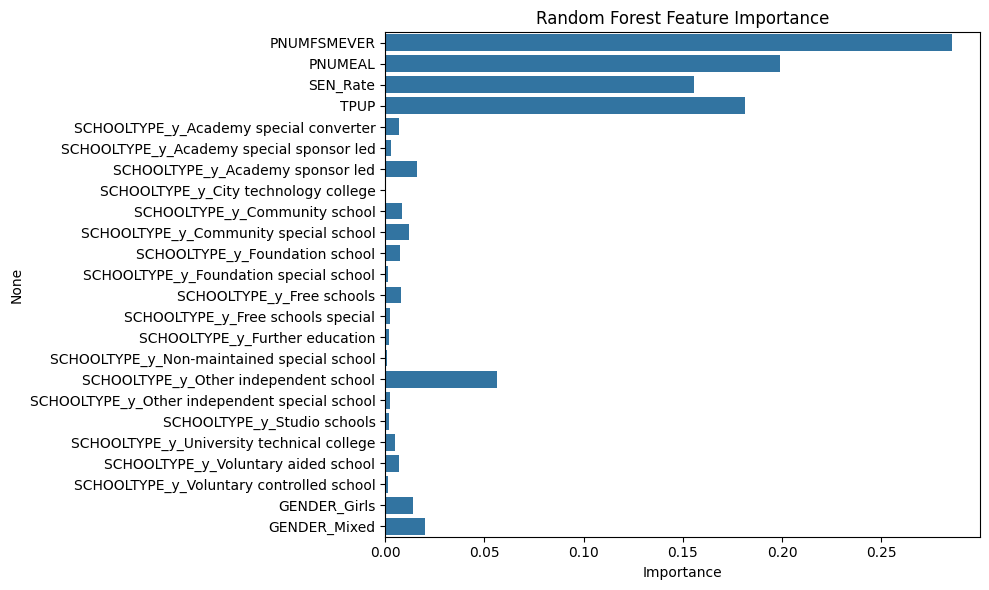

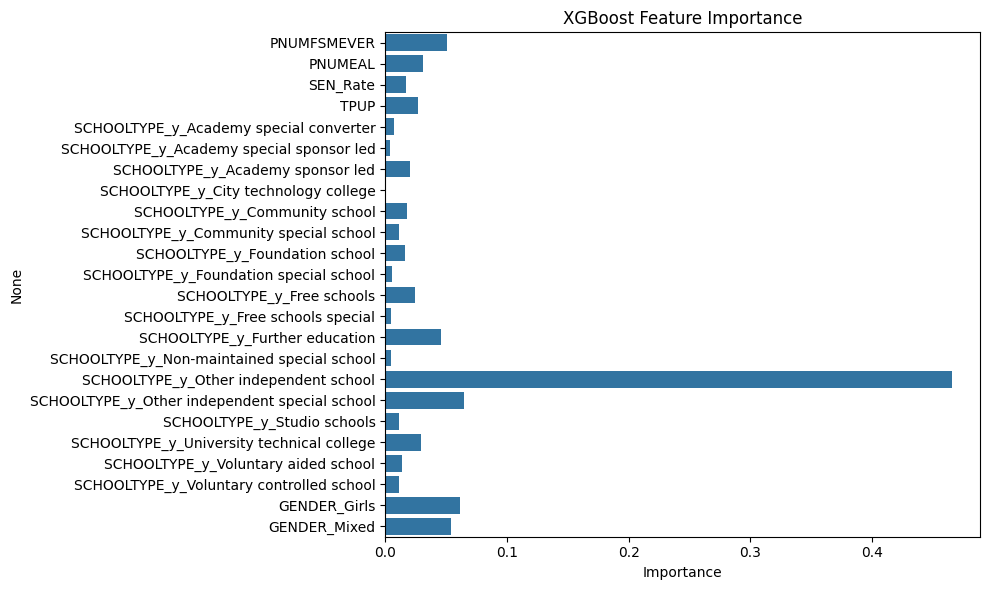

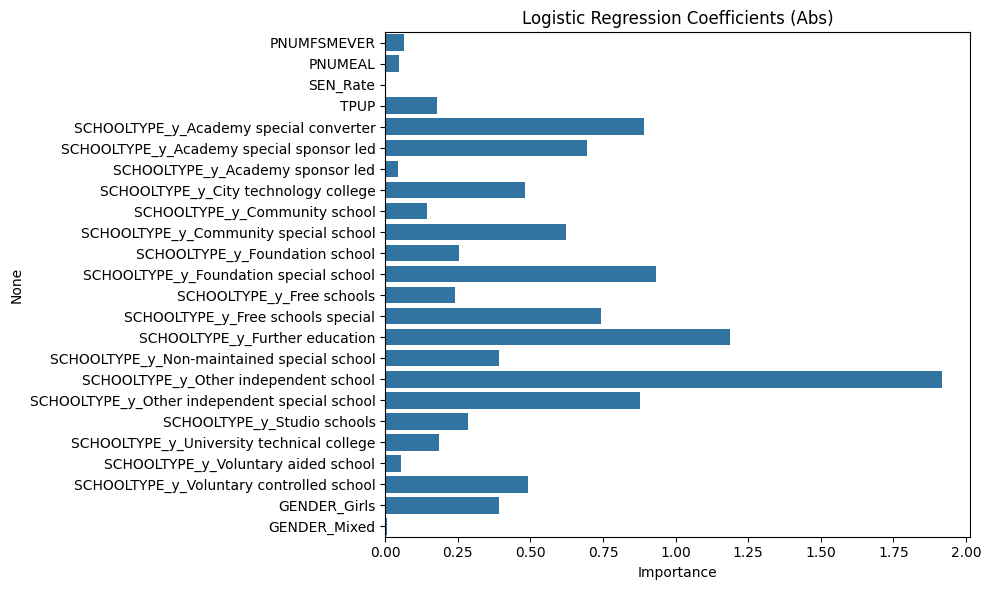

In [309]:
plot_importance("Random Forest Feature Importance", X.columns, rf_model.feature_importances_)
plot_importance("XGBoost Feature Importance", X.columns, xgb_model.feature_importances_)
plot_importance("Logistic Regression Coefficients (Abs)", X.columns, np.abs(lr_model.coef_[0]))

# Confusion Matrix

In [310]:
# Define the confusion matrix function
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion(title, y_true, y_pred, cmap):
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=le.classes_,
        cmap=cmap,
        xticks_rotation=45
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

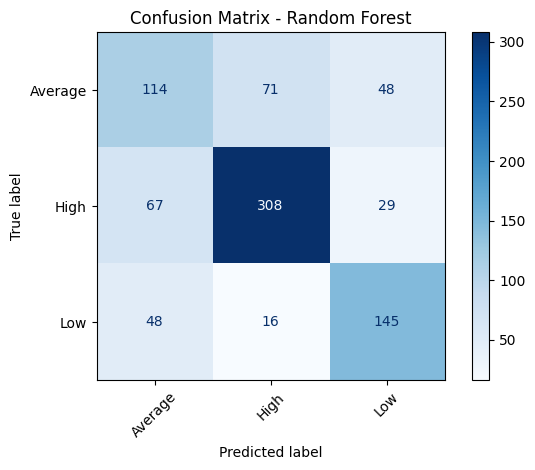

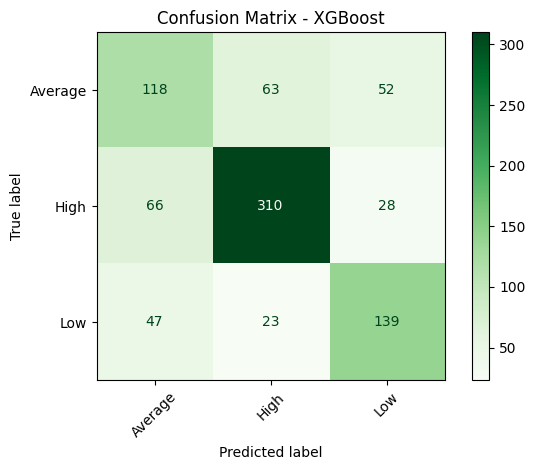

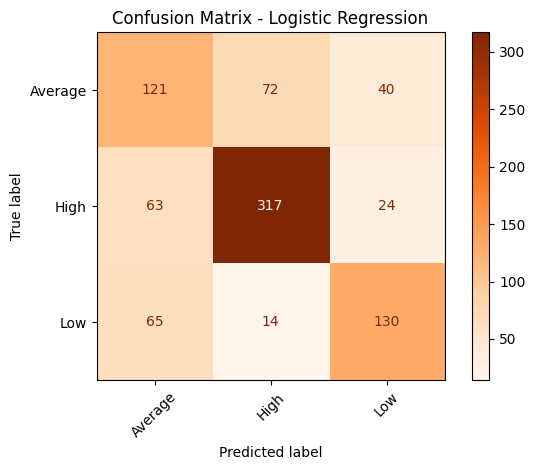

In [311]:
plot_confusion("Confusion Matrix - Random Forest", y_test, rf_pred, cmap='Blues')
plot_confusion("Confusion Matrix - XGBoost", y_test, xgb_pred, cmap='Greens')
plot_confusion("Confusion Matrix - Logistic Regression", y_test, lr_pred, cmap='Oranges')

**Insights:**
- Models most accurately predicted 'High' and 'Low' schools
- 'Average' schools were frequently misclassified ➜ feature refinement needed

# adjust parameter

In [312]:
# Logistic Regression parameter adjustment
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
grid_lr.fit(X_train, y_train)

print("Best params (LR):", grid_lr.best_params_)
print("Best CV score (LR):", grid_lr.best_score_)

Best params (LR): {'C': 1, 'solver': 'lbfgs'}
Best CV score (LR): 0.6753349706764092


In [313]:
# Random Forest tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

print("Best params (RF):", grid_rf.best_params_)
print("Best CV score (RF):", grid_rf.best_score_)


Best params (RF): {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (RF): 0.6676509662363543


In [314]:
# XGBoost parameters
import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid_xgb,
    cv=5
)
grid_xgb.fit(X_train, y_train)

print("Best params (XGB):", grid_xgb.best_params_)
print("Best CV score (XGB):", grid_xgb.best_score_)

Best params (XGB): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV score (XGB): 0.6679442021448612
